# An analysis of the State of the Union speeches - Part 1

## Data Ingestion

We begin by ingesting the dataset. We have a text file of all speeches with some accompanying metadata (the President who delivered the speech, the type of speech, and date of delivery). We will load the speeches into a CSV file whose columns are the metadata fields (the President who delivered the speech, the type of speech, and date of delivery), and then every unique word delivered in all of the speeches, and the count for each one. This CSV file means we can easily access the data in question without having to repeat the script which loads and organizes the data in the txt file. Once a CSV is made, we can easily read it into a Pandas dataframe.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import shelve
import re #for string splitting

plt.style.use('seaborn-dark')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

/Users/Kenz/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/Kenz/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


First, we'll define some useful functions.

In [2]:
speech_metadata = pd.DataFrame(columns = ['President', 'Speech', 'Date', 'Date (String)'])

def read_speech_meta(string): 
    vals = string.split(',')
    d = {}
    d['President'] = vals[0].strip()
    d['Speech'] = vals[1].strip()
    date_string = (vals[2] + vals[3]).strip()
    d['Date'] = datetime.datetime.strptime(date_string, '%B %d %Y')
    d['Date (String)'] = date_string
    return d

'''Custom function designed to read a list of strings that contain 
the speech name, speaker, and date corresponding to a Presidential speech.
Example: ['State of the Union Address', 'George Washington', 'January 8, 1790']'''

def read_speech_meta_list(str_list): 
    d = {}
    d['President'] = str_list[0].strip()
    d['Speech'] = str_list[1].strip()
    date_string = (str_list[2] + str_list[3]).strip()
    d['Date'] = datetime.datetime.strptime(date_string, '%B %d, %Y')
    d['Date (String)'] = date_string
    return d

SEPARATORS = '[\'\":\n\t,-.()%$;?!@#$^&_+=<>/\{}\[\] ]'

'''Removes all occurrences of the empty string from a list of strings'''
def remove_empty_strings(list_of_strings): 
    return list(filter(lambda elem: elem != '', list_of_strings)) 

'''Splits lines according to the SEPARATORS above and the python regex package.
Returns a list of all the words in the speech, with repeats.'''
def split_text_lines(list_of_lines): 
    all_words_with_repeats = []
    for line in list_of_lines: 
        split_line = remove_empty_strings(re.split(SEPARATORS, line))
        all_words_with_repeats += split_line
    return all_words_with_repeats

'''Returns a dictionary whose keys are POSSIBLE_WORDS. The value at each key 
is an integer which is the number of occurrences of that word in WORD_OCURRENCE_LIST'''
def word_count_dict(possible_words, word_occurrence_list): 
    count_dict = dict.fromkeys(possible_words, 0)
    for word in word_occurrence_list: 
        count_dict[word] += 1 
    return count_dict

In [3]:
'''In this cell, we read the meta-data of the speeches and store it in a dataframe.'''

addresses_df = pd.DataFrame(index=['President', 'Speech', 'Date', 'Date (String)'])
# addresses_df = addresses_df.fillna(0)
# addresses_df = addresses_df.dropna()

with open('data/stateoftheunion1790-2017.txt', 'r') as g:
    txt_file_chunks = g.read().split('***') 
    meta = txt_file_chunks[0].split('\n') #f[0] is the metadata entry. split by line. 
    contents_index = meta.index('CONTENTS') #get the index of the line that indicates the beginning of contents.
    meta = remove_empty_strings(meta[contents_index + 2:])
    for line in meta: 
        new_series = pd.Series(read_speech_meta(line))
        addresses_df = addresses_df.append(new_series, ignore_index=True)
# addresses_df = addresses_df.drop(labels=[0, 1, 2, 3])
addresses_df.dropna(inplace=True)
addresses_df.reset_index(drop=True, inplace=True)

In [4]:
'''Function to convert Date string in CSV file to Datetime object.
In Pandas, this is a Timestamp object.'''
str_to_date = lambda date_str: datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

Let's take a first look at a high-level summary of what we have so far:

In [5]:
# Describe the presidents data
addresses_df.describe()

,Date,Date (String),President,Speech
count,227,227,227,227
unique,227,227,42,4
top,1976-01-19 00:00:00,January 3 1938,Franklin D. Roosevelt,State of the Union Address
freq,1,1,12,222
first,1790-01-08 00:00:00,NaN,NaN,NaN
last,2017-02-27 00:00:00,NaN,NaN,NaN


Let's find the dates of the first and last address, and how much time has passed between those:

In [6]:
from dateutil.relativedelta import relativedelta

print('Date of first speech: ', addresses_df['Date'].min().date())
print('Date of last speech: ', addresses_df['Date'].max().date())
print('Time between these speeches: ', relativedelta(addresses_df['Date'].max().date(), 
                                                     addresses_df['Date'].min().date()))

Date of first speech:  1790-01-08
Date of last speech:  2017-02-27
Time between these speeches:  relativedelta(years=+227, months=+1, days=+19)


So there have been 227 years, 1 month, and 19 days between the oldest speech and the most recent one. 

Let's see during which months are the speeches most frequently delivered:

In [7]:
# This is a count of the number of addresses delivered on any given month
# addresses_df['Date'].iloc[0].day
import calendar

#initialize all counts to 0
date_count_dict = {x:0 for x in range(1, 13)}

for date in addresses_df['Date']: 
    date_count_dict[date.month] += 1
    
#intialize lists to be used in plotting
month_names = []
month_counts = []

#print 
for month_num in range(1, 13):
    name = calendar.month_name[month_num]
    count = date_count_dict[month_num]
    month_names.append(name)
    month_counts.append(count)
    print('{}: {}'.format(name, count))

January: 75
February: 12
March: 0
April: 0
May: 0
June: 0
July: 0
August: 0
September: 2
October: 3
November: 11
December: 124


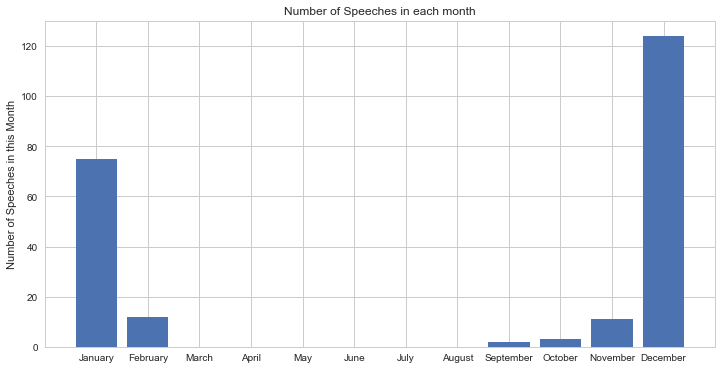

In [8]:
# And this is a plot of these:

plt.figure(figsize=(12, 6))

y_pos = np.arange(len(month_names))

plt.bar(y_pos, month_counts)
plt.xticks(y_pos, month_names)
plt.ylabel('Number of Speeches in this Month')
plt.title('Number of Speeches in each month')
plt.savefig('fig/addresses_month.png');
plt.show(); 

Let's look at the distribution of differences between successive speeches:

Where is the largest gap? We can ask the `ddiff` series for its location:

In [9]:
# this is the index of the largest gap:
date_diff = addresses_df['Date'] - addresses_df['Date'].shift(1)
ddiff = date_diff[1:]
dgap = ddiff.argmax()
dgap

104

Let's look at the dates around this index:

In [10]:
addresses_df['Date'][dgap-2 : dgap+2]

102   1891-12-09
103   1892-12-06
104   1897-12-06
105   1898-12-05
Name: Date, dtype: datetime64[ns]

As well as a plot of these times:

/Users/Kenz/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


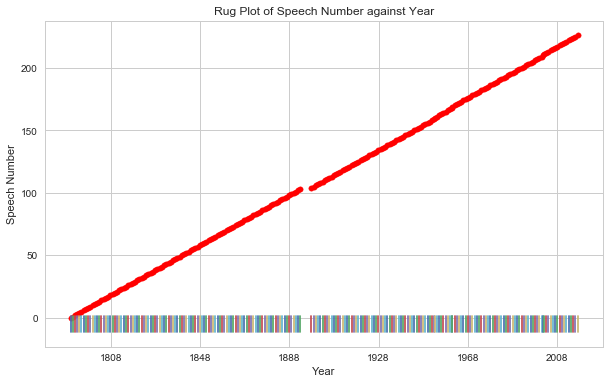

In [11]:
# A plot of the times, along with 'rug' markers on the x axis.
fig = plt.figure()
ax1 = plt.subplot()

#convert the Pandas timestap objects to date objects
date_objs = [addresses_df['Date'].iloc[i].date() for i in range(len(addresses_df['Date']))]

#create a scatter plot of the dates against the number of elements in the Date series 
ax1.scatter(date_objs, np.arange(len(addresses_df['Date'])), s=30, c='r')
sns.rugplot(date_objs, ax=ax1) #add the rugplot

ax1.set_xlabel('Year')
ax1.set_ylabel('Speech Number')
ax1.set_title('Rug Plot of Speech Number against Year')
fig.show();
fig.savefig('fig/timeline.png');

What happened at that gap?

## Discussion of Gap

The gap in the data occurs between 1892 and 1897. There are no speeches from 1893 to 1896, during the second term of Grover Cleveland. After some research, a [UCSB database](http://www.presidency.ucsb.edu/sou.php) confirms that Cleveland did in fact give four State of the Union speeches during his second term. The dataset is missing these speeches, and is thus incomplete. In particular, analysis of Grover Cleveland should be considered severely limited.

## Intermediate results

Let's save some intermediate results for further analysis. This lets us work on subsequent notebooks  without rerunning this one.  We use the Pandas HDF5 support for efficient and type-safe serialization of data frames, and the python builtin [shelve](https://docs.python.org/3/library/shelve.html) module for simple Python variables.  We'll create for each notebook variable stores with the notebook number, one for dataframes (`df1.h5`, `df2.h5`, etc.) and one for python variables (`vars1.db`, `vars2.db`, etc.).  These will all go into the `results/` subdirectory.

In [12]:
addresses_df.to_hdf('results/addresses_df_1.h5', 'addresses_df')